In [2]:
from pathlib import Path

In [7]:
from lightgbm import LGBMRegressor

In [10]:
from sklearn.model_selection import train_test_split
import seaborn as sns

In [4]:
import pandas as pd
import numpy as np
from lgbm import LG

In [11]:
sns.set(rc={"figure.figsize": (20, 5)})

## Loads

In [12]:
path = Path('../data/external/')
!ls {path}

activity_target.csv  pressure_he_target.csv	  sensors.csv
coke_target.csv      reactor_pressure_target.csv  temp_on_he_target.csv


In [13]:
dataframe_url = 'sensors.csv'

In [14]:
target_urls = ['activity_target.csv', 'pressure_he_target.csv', 'coke_target.csv', 
 'reactor_pressure_target.csv', 'temp_on_he_target.csv']

In [15]:
target_dataframes = []
for url in target_urls:
    target_dataframes.append(pd.read_csv(path/url,
                parse_dates=['timestamp'], 
                index_col=['timestamp']))

In [16]:
targets = pd.concat(target_dataframes, axis=1)
targets.columns = ['y5', 'y4', 'y1', 'y2', 'y3']

In [17]:
targets.head()

,y5,y4,y1,y2,y3
timestamp,,,,,
2016-10-24 16:00:00,-54.963407,32.995096,2.714220,64.224924,560.094747
2016-10-24 17:00:00,-54.275879,33.162564,2.709524,64.371366,560.478644
2016-10-24 18:00:00,-54.870874,33.283977,2.709705,64.294914,560.098119
2016-10-24 19:00:00,-54.879948,33.144032,2.715567,64.307611,560.073475
2016-10-24 20:00:00,-55.025885,33.053872,2.706246,64.231108,560.312775


In [18]:
sensors = pd.read_csv(path/dataframe_url, parse_dates=['timestamp'])

In [19]:
sensors.T

,0,1,2,3,4,5,6,7,8,9,...,13262,13263,13264,13265,13266,13267,13268,13269,13270,13271
timestamp,2016-10-24 16:00:00,2016-10-24 17:00:00,2016-10-24 18:00:00,2016-10-24 19:00:00,2016-10-24 20:00:00,2016-10-24 21:00:00,2016-10-24 22:00:00,2016-10-24 23:00:00,2016-10-25 00:00:00,2016-10-25 01:00:00,...,2018-04-30 06:00:00,2018-04-30 07:00:00,2018-04-30 08:00:00,2018-04-30 09:00:00,2018-04-30 10:00:00,2018-04-30 11:00:00,2018-04-30 12:00:00,2018-04-30 13:00:00,2018-04-30 14:00:00,2018-04-30 15:00:00
f_0,NaN,NaN,NaN,NaN,98.9127,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,99.0537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_1,NaN,NaN,NaN,NaN,0.336871,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.349084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_2,NaN,NaN,NaN,NaN,27.8974,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.9072,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_3,-0.00538321,0.103383,-0.0048521,0.131502,0.0181929,0.00860145,0.0186855,-0.010295,0.0172582,0.00807089,...,0.033991,0.00491675,0.00576931,-0.0182285,-0.0108977,0.0069725,0.010679,-0.00661649,0.000707764,0.0169344
f_4,6.25191,6.46508,6.31527,6.43795,6.21786,6.34401,6.22559,5.87599,5.74683,5.83773,...,0.0298159,0.143796,0.122485,0.121472,0.127025,0.00220551,0.0492557,0.0743141,0.105542,0.0239832
f_5,0.0223037,0.0116926,-0.00307206,-0.0122403,0.0155345,-0.0213528,-0.00124564,0.00662123,-0.0168667,-0.00152409,...,0.00954087,-0.0377618,0.00576362,-0.0151338,-0.00551036,-0.0209024,0.0565243,0.00816418,-0.00226166,0.00145374
f_6,1.4667,1.26701,1.21685,1.16237,1.28753,1.20728,1.29017,1.41675,1.26293,1.38025,...,0.139093,0.238765,0.136352,0.101557,0.124532,0.0739482,-0.09259,0.0556571,0.161125,-0.0169616
f_7,11.1739,12.9876,12.8248,6.67832,5.74119,6.4352,10.8708,14.94,10.8624,9.84177,...,3.60166,0.900297,-3.30977,-1.09239,4.28618,-1.04522,0.61265,3.03149,3.74026,-3.26811
f_8,236232,236736,235780,236091,234845,235558,235863,235594,235060,236566,...,194684,193250,194489,193567,195674,195904,195010,195797,195143,190021


## Validation Set

In [20]:
def create_validation(data, target, val_size=1400):
    label_size = len(target)
    train_size = len(target) - val_size
    X_train = data.iloc[:train_size, :]
    y_train = target.iloc[:train_size, :]
    X_test = data.iloc[train_size:label_size, :]
    y_test = target.iloc[train_size:label_size, :]
    return X_train, y_train, X_test, y_test

In [21]:
def rmse(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

In [22]:
def validate(y_actual, y_predicted, message=None, check_only=True):
    metric = rmse(y_actual, y_predicted)
    if check_only:
        return metric
    METRICS.append((message, metric))
    print(METRICS)

In [23]:
train = sensors.set_index('timestamp').iloc[:10400, :]

In [24]:
def merge_with_targets(train, targets, target_col):
    return train.join(targets.drop(target_col, axis=1), how='right')

In [145]:
def run_lgbm(sensors, targets, target_col, test_size=1000, use_targets=False, reg=None):
    train = sensors.set_index('timestamp').iloc[:len(targets), :]
    if use_targets:
        train = merge_with_targets(train, targets, target_col)  
    X_train, X_test, y_train, y_test = train_test_split(train, targets, 
                                                        test_size=test_size, 
                                                        shuffle=False)
    if not reg:
        reg = LGBMRegressor(random_state=42)
    reg.fit(X_train, y_train[target_col])
    preds = np.array(reg.predict(X_test))
    #print('Use targets', use_targets)
    metric = validate(y_test[target_col], preds)
    print(target_col, 'RMSE:', metric)
    print('')
    return preds

In [26]:
lag_matrix = np.zeros([len(train.columns), 24])

In [27]:
max_lag = 500

def detect_sensor_lags(train, targets, target_col):
    cols = []
    lag_matrix = np.zeros([len(train.columns), max_lag//23])
    print(lag_matrix.shape)
    for i, col in enumerate(train.columns):
        for j, lag in enumerate(range(0, max_lag, 24)):
            lag_matrix[i, j] = train[col].shift(lag).corr(targets[target_col])
        cols.append(col)
    #lag_matrix.index = cols
    return lag_matrix, cols

In [40]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
def plot_lag_corellation(train, targets, col):
    lag_matrix = detect_sensor_lags(merge_with_targets(train, targets, col), targets, col)

    ax = plt.figure(figsize=(10, 15))
    ax = plt.matshow(pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(lag_matrix).abs().T)).T, fignum=1);

In [42]:
test_col = 'y1'

In [43]:
lags, cols = detect_sensor_lags(train, targets, test_col)

(48, 21)


In [44]:
lags = pd.DataFrame(lags).T

In [45]:
lags.columns = cols

In [46]:
lags.index = [x for x in range(0, max_lag, 24)]

In [87]:
df = pd.DataFrame()
for col in lags.columns:
    shifts = lags[col].abs().sort_values(ascending=False).index
    for shift in shifts:
        df[col + '_shift_' + str(shift)] = sensors[col].shift(shift)

In [88]:
df['timestamp'] = sensors['timestamp']
preds =run_lgbm(df.iloc[800:, :], targets.iloc[800:, :], test_col, use_targets=False)

y1 RMSE: 0.21458762536282477



### Feature Selection

In [89]:
from sklearn.feature_selection import SelectFromModel

In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [136]:
rf = RandomForestRegressor()
#rf = SVR(C=0.01)

In [137]:
rf.fit(df.iloc[9000:10400, :].drop('timestamp', axis=1).fillna(-1), targets.y1.tail(1400))

/home/ds/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [138]:
m = SelectFromModel(rf, prefit=True)

In [139]:
X_selected = pd.DataFrame(m.transform(df.drop('timestamp', axis=1).fillna(-1)))

In [187]:
reg = LGBMRegressor(max_depth=-1, n_estimators=90)

In [193]:
X_selected['timestamp'] = sensors['timestamp']
preds =run_lgbm(X_selected.iloc[800:, :], targets.iloc[800:, :], test_col, use_targets=False, reg=reg)

y1 RMSE: 0.21562900614719419



In [73]:
preds = run_lgbm(sensors.iloc[800:, :], targets.shift(-290).iloc[800:-290, :], test_col, use_targets=True)

y1 RMSE: 0.22999691539713055



In [1467]:
lags['f_0'].abs().sort_values(ascending=False).index[:5]

Int64Index([0, 360, 288, 336, 384], dtype='int64')

In [751]:
train.fillna(method='ffill').iloc[[324, 325, 326], [0]].mean().values[0]

98.83039651054476

In [3]:
from scipy.stats import norm

In [843]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(lags.T[0])
    print(dist_name, param)
    # here's the parameters of your distribution, scale, location

gamma (46715.475675408365, -6.374281491210314, 0.00013752346262066662)
beta (4.722389652623067, 5.377126308683695, -0.043057720526629026, 0.19933148007161394)
rayleigh (-0.016237657198935534, 0.05146087262850453)
norm (0.050192603532644445, 0.029723618460595843)
pareto (4.298865081839758, -0.2680608518517317, 0.25482428111543975)


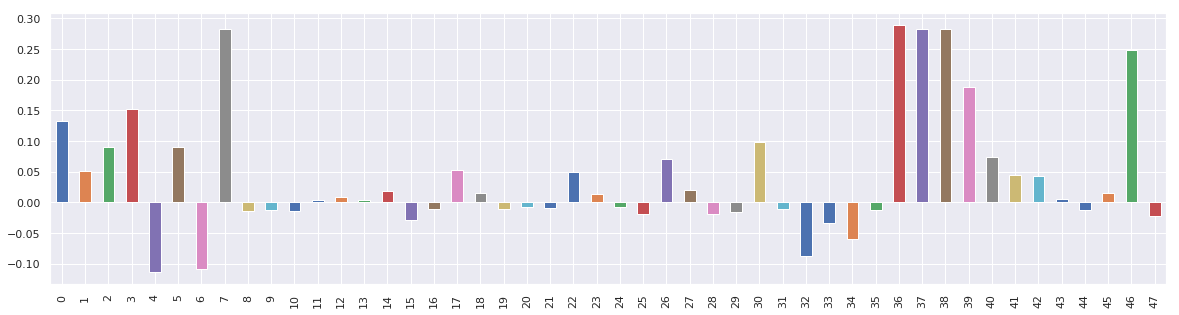

In [807]:
pd.Series(col_corr).plot(kind='bar')

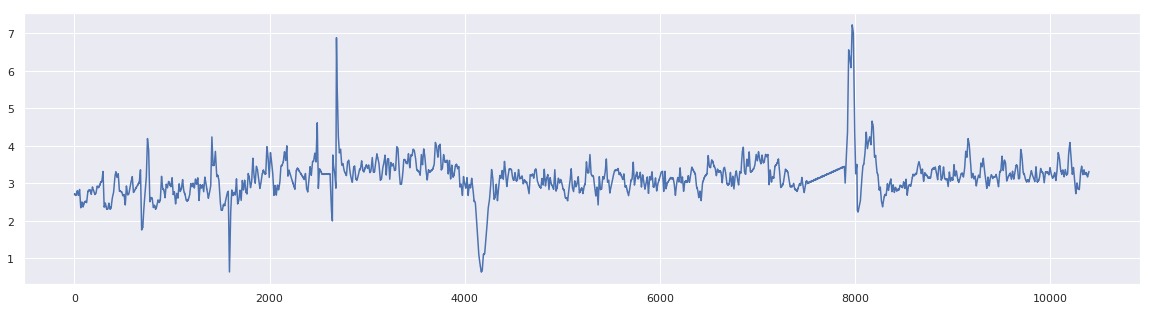

In [668]:
targets.reset_index().y1.plot()

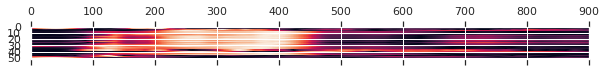

In [660]:
plot_lag_corellation(train, targets, 'y1')

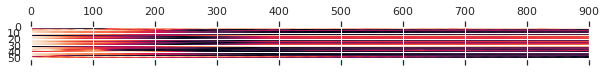

In [663]:
plot_lag_corellation(train, targets, 'y2')

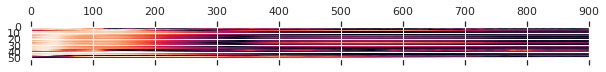

In [664]:
plot_lag_corellation(train, targets, 'y3')

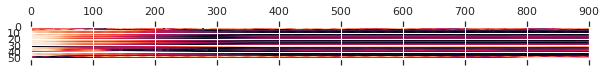

In [665]:
plot_lag_corellation(train, targets, 'y4')

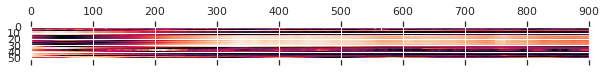

In [666]:
plot_lag_corellation(train, targets, 'y5')

In [1489]:
run_lgbm(sensors.iloc[800: ,:], targets.iloc[800:, :], 'y2', use_targets=False)

y2 RMSE: 3.10429364573134



In [1325]:
for col in ['y1', 'y2', 'y3', 'y4', 'y5']:
    for b in [False]:
        run_lgbm(sensors.fillna(method='pad'), targets.shift(-350).fillna(method='ffill'), col, use_targets=b)

y1 RMSE: 0.20620020118097102

y2 RMSE: 3.1295743163139083

y3 RMSE: 2.304381202505279

y4 RMSE: 1.7108415558073948

y5 RMSE: 0.49490509082826806



In [433]:
for col in ['y1', 'y2', 'y3', 'y4', 'y5']:
    for b in [False]:
        run_lgbm(sensors.fillna(method='pad'), targets, col, use_targets=b)

y1 RMSE: 0.29722670214500657

y2 RMSE: 3.3934978663218223

y3 RMSE: 3.0808294529264613

y4 RMSE: 1.6325512824755217

y5 RMSE: 0.5884578084847693



## Corellations

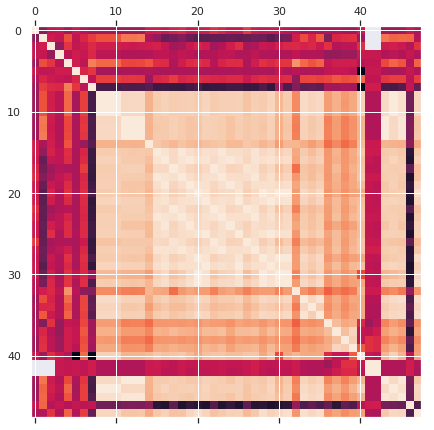

In [336]:
plt.matshow(train.corr());

In [326]:
def plot_corr_with_target(train, targets, target_col):
    train_w_targets = merge_with_targets(train, targets, target_col)
    corellations = train_w_targets.corrwith(targets[target_col])
    corellations.plot(kind='bar');

        add error to USED TARGETS

In [ ]:
for shift in [0, 800, 25]

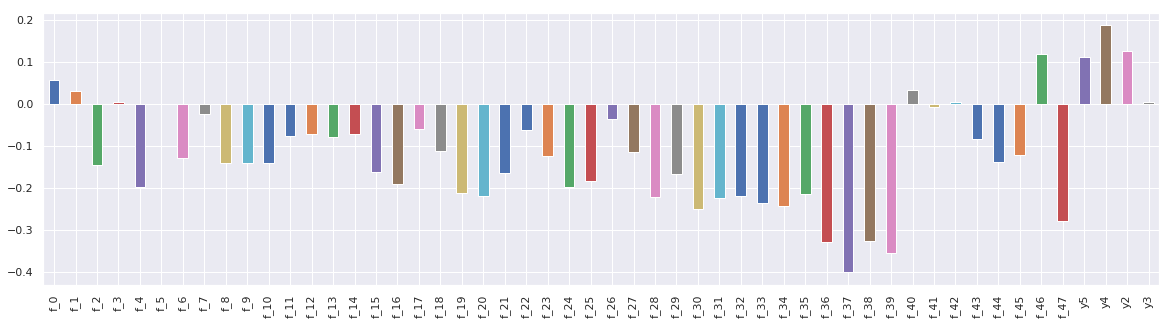

In [954]:
plot_corr_with_target(train.shift(100), targets, 'y1')

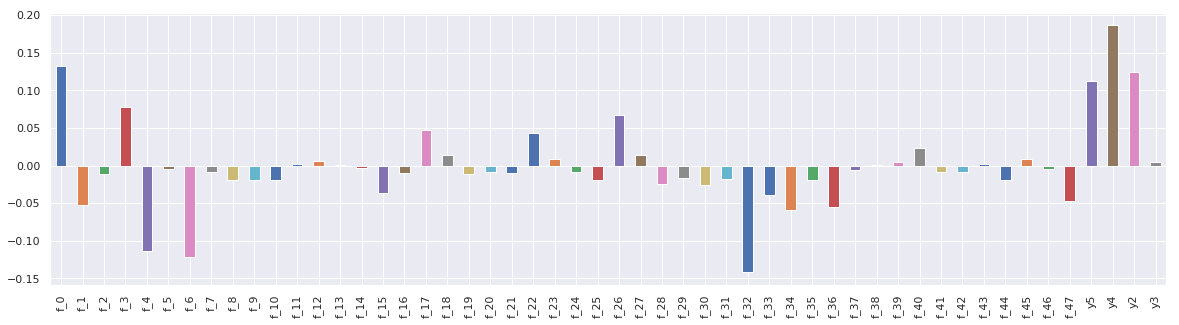

In [372]:
plot_corr_with_target(train, targets, 'y1')

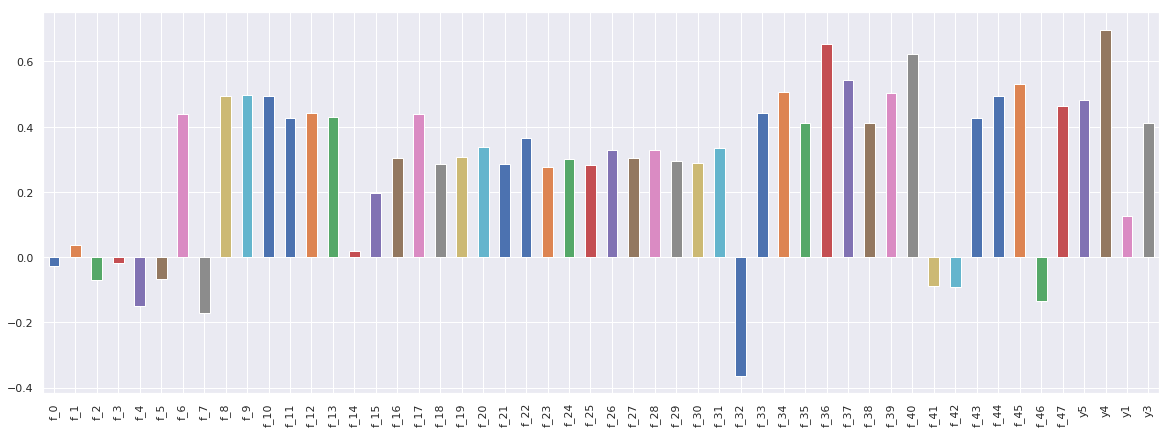

In [331]:
plot_corr_with_target(train, targets, 'y2')

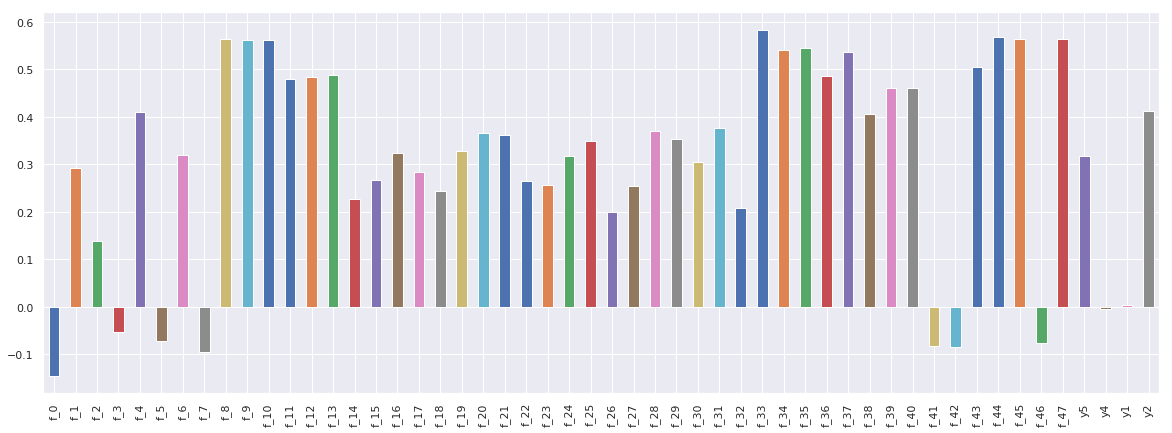

In [332]:
plot_corr_with_target(train, targets, 'y3')

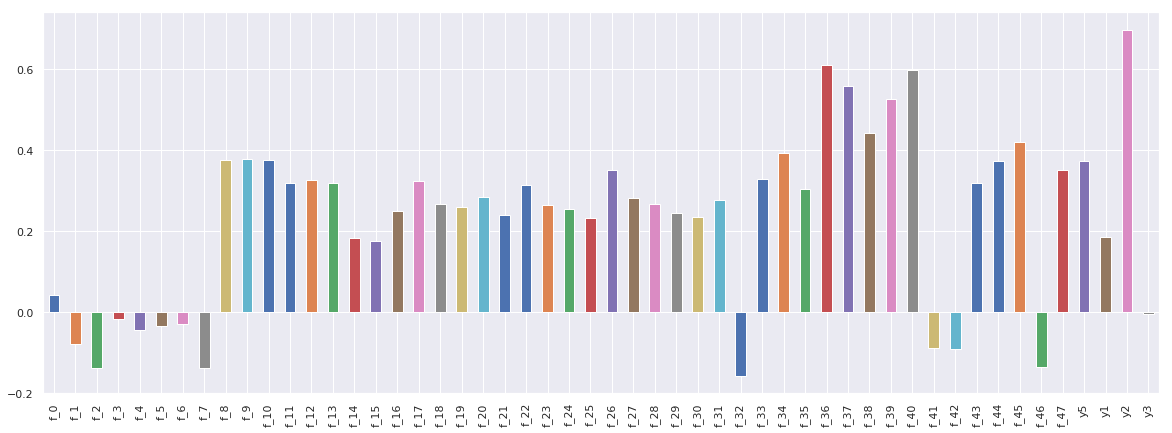

In [333]:
plot_corr_with_target(train, targets, 'y4')

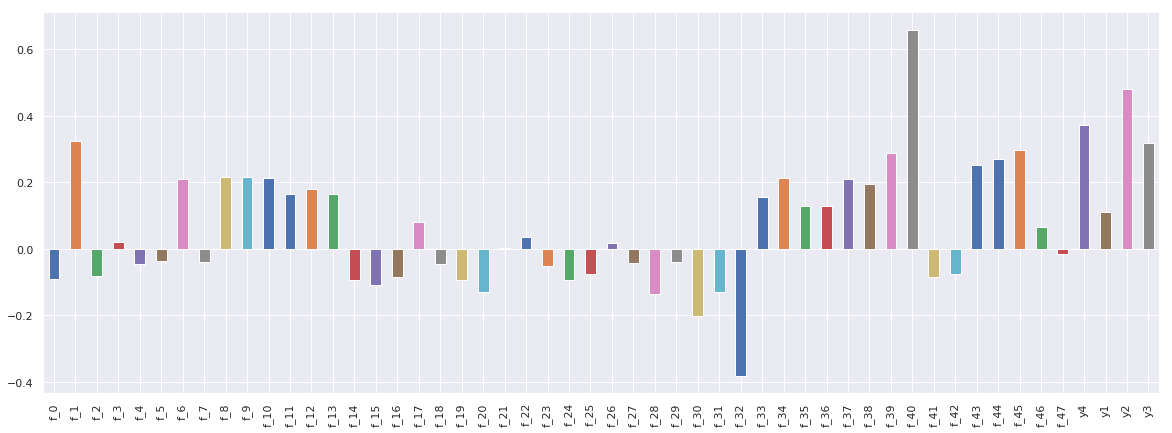

In [334]:
plot_corr_with_target(train, targets, 'y5')

## Train Test Corr

In [217]:
a = np.array([1, 2, 3])
b = np.array([5, 6])
c = np.array([3, 2])

In [203]:
from scipy.stats import ttest_ind

In [228]:
ttest_ind(a, c)

Ttest_indResult(statistic=-0.6, pvalue=0.590801208053989)

In [199]:
test = sensors.loc[10400:, :]

In [227]:
for col in train.columns:
    print(col, round(ttest_ind(np.array(train[col].fillna(-1)), np.array(test[col].fillna(-1))).pvalue, 4))

f_0 0.1428
f_1 0.1016
f_2 0.0544
f_3 0.0015
f_4 0.0
f_5 0.0
f_6 0.0
f_7 0.0
f_8 0.9448
f_9 0.941
f_10 0.9782
f_11 0.0
f_12 0.0
f_13 0.0
f_14 0.0
f_15 0.0036
f_16 0.0
f_17 0.0
f_18 0.0
f_19 0.0
f_20 0.0
f_21 0.0
f_22 0.0
f_23 0.0001
f_24 0.0
f_25 0.0
f_26 0.0
f_27 0.0
f_28 0.0
f_29 0.0
f_30 0.0
f_31 0.0
f_32 0.0
f_33 0.0138
f_34 0.0
f_35 0.0
f_36 0.0
f_37 0.0
f_38 0.0
f_39 0.0
f_40 0.0
f_41 0.5814
f_42 0.5724
f_43 0.0
f_44 0.0095
f_45 0.0
f_46 0.0942
f_47 0.0


## Missing Values

In [349]:
from quilt.data.ResidentMario import missingno_data

In [359]:
collisions = missingno_data.nyc_collision_factors()

In [360]:
collisions = collisions.replace("nan", np.nan)


In [362]:
import missingno as msno

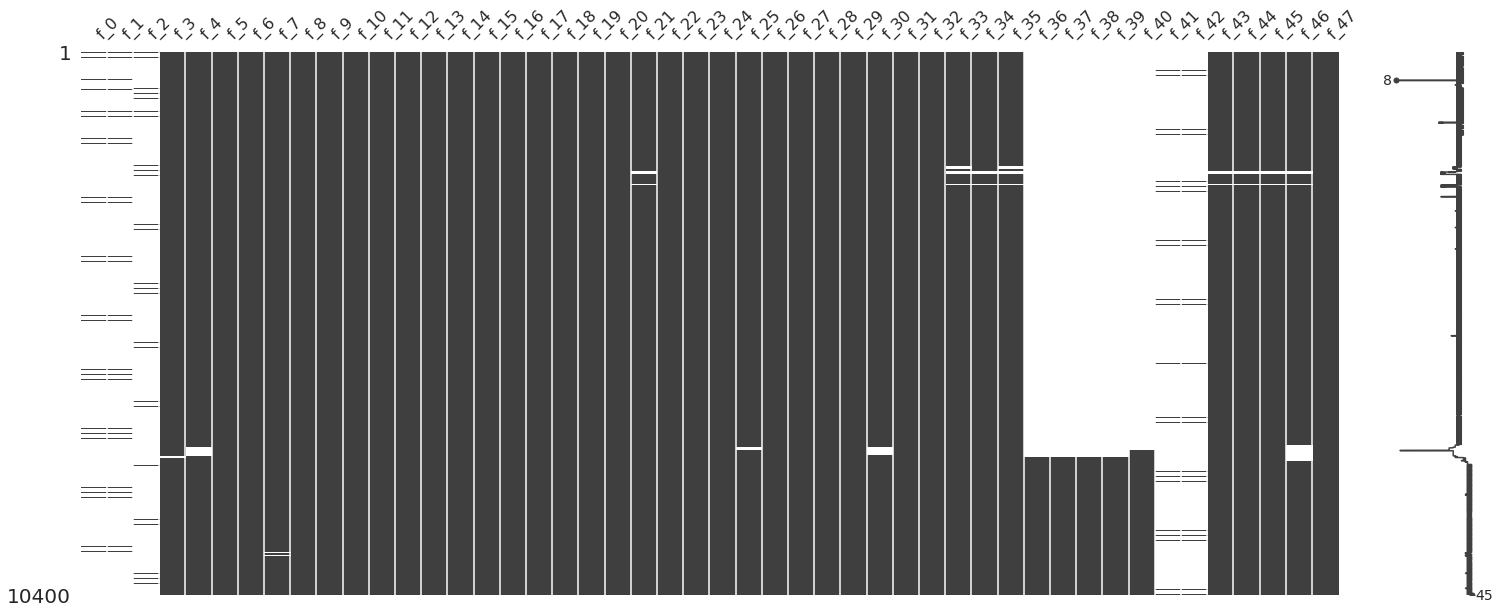

In [363]:
msno.matrix(train)

## Schedule NA Fill